In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import keras

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras import layers

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
im_dir = r"C:\Users\reekithak\Downloads\CERTH_ImageBlurDataset\TrainingSet"

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  im_dir,
  validation_split=0.2,
  seed=123,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1100 files belonging to 2 classes.
Using 880 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  im_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1100 files belonging to 2 classes.
Using 220 files for validation.


In [8]:
class_s =  train_ds.class_names

In [9]:
class_s

['blurred', 'clear']

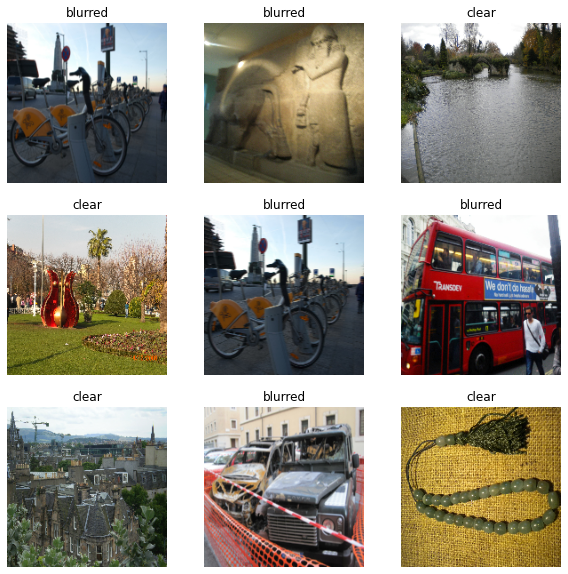

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_s[labels[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)

    print(labels_batch.shape)
    break
  

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [15]:
IMG_SIZE = (180,180)

In [16]:
IMG_SHAPE = IMG_SIZE + (3,)

In [17]:
input_tensor = IMG_SHAPE

In [18]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_180"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 181, 181, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [20]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [21]:
base_model.trainable = False

In [22]:
base_model.summary()

Model: "mobilenetv2_1.00_180"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 181, 181, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 90, 90, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 90, 90, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [23]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [24]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [25]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [26]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 180, 180, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 180, 180, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_180 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [28]:
len(model.trainable_variables)

2

In [31]:
initial_epochs = 5
loss0, accuracy0 = model.evaluate(val_ds)

7/7 [==============================] - 3s 427ms/step - loss: 0.6931 - accuracy: 0.4273


In [34]:
model.fit(train_ds,validation_data=val_ds,epochs=2)

Epoch 1/2
28/28 [==============================] - 19s 695ms/step - loss: 0.6926 - accuracy: 0.4273 - val_loss: 0.6925 - val_accuracy: 0.4273
Epoch 2/2
28/28 [==============================] - 20s 697ms/step - loss: 0.6924 - accuracy: 0.4273 - val_loss: 0.6924 - val_accuracy: 0.4273


new_train 

In [35]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [36]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [37]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)       

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
28/28 [==============================] - 16s 554ms/step - loss: 0.9584 - accuracy: 0.5284 - val_loss: 0.6484 - val_accuracy: 0.5727
Epoch 2/10
28/28 [==============================] - 15s 554ms/step - loss: 0.6208 - accuracy: 0.6125 - val_loss: 0.6185 - val_accuracy: 0.7364
Epoch 3/10
28/28 [==============================] - 16s 565ms/step - loss: 0.5387 - accuracy: 0.7545 - val_loss: 0.6179 - val_accuracy: 0.6500
Epoch 4/10
28/28 [==============================] - 16s 556ms/step - loss: 0.4495 - accuracy: 0.7920 - val_loss: 0.4202 - val_accuracy: 0.8273
Epoch 5/10
28/28 [==============================] - 15s 552ms/step - loss: 0.3216 - accuracy: 0.8739 - val_loss: 0.4455 - val_accuracy: 0.8455
Epoch 6/10
28/28 [==============================] - 16s 559ms/step - loss: 0.2345 - accuracy: 0.8977 - val_loss: 0.4348 - val_accuracy: 0.8364
Epoch 7/10
28/28 [==============================] - 16s 558ms/step - loss: 0.1824 - accuracy: 0.9182 - val_loss: 0.5346 - val_accuracy: 0.8045

In [41]:
model.save("model_10.h5")

visualize

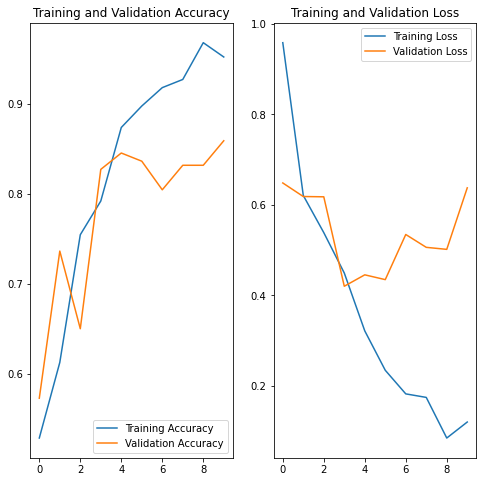

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

predict

In [43]:
dig_blur_dir = r"C:\Users\reekithak\Downloads\CERTH_ImageBlurDataset\TrainingSet\blurred\13-08-07_2012.jpg"

In [44]:
img = keras.preprocessing.image.load_img(
    dig_blur_dir, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_s[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to blurred with a 80.89 percent confidence.
